<a href="https://colab.research.google.com/github/SuperNZH/KPMG_DataAnalytics_Virtual_Program/blob/main/2_Data_Insights/data_insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Sprocket Central Pty Ltd** has given us a new list of 1000 potential customers with their demographics and attributes. However, these customers do not have prior transaction history with the organisation. 

Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, recommend which of these 1000 new customers should be targeted to drive the most value for the organisation. 

---

***OBJECTIVE***

*   Data Exploration
*   Model Development
*   Interpretation



***PROCESS*** 

1. Understanding the data distributions
2. Feature engineering
3. Data transformations
4. Modelling
5. Results interpretation and reporting.

PowerPoint presentation includes a detailed approach for our strategy behind each of the 3 phases including activities involved in each - i.e. understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting. This detailed plan needs to be presented to the client to get a sign-off.

# Mount Drive and Read Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "/content/drive/MyDrive/Colab_Notebooks/my_project/kpmg_virtual_intern/kpmg.xlsx"

# For Training
transactions = pd.read_excel(path, sheet_name=1, header=1)
customer_demographic = pd.read_excel(path, sheet_name=3, header=1)
customer_address = pd.read_excel(path, sheet_name=4, header=1)

# For Prediction
new_customer_list = pd.read_excel(path, sheet_name=2, header=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  if __name__ == '__main__':


In [3]:
transactions.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [4]:
customer_demographic.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure'],
      dtype='object')

In [5]:
customer_address.columns

Index(['customer_id', 'address', 'postcode', 'state', 'country',
       'property_valuation'],
      dtype='object')

# EDA

The above steps are intended to get a rough and quick overview of the new data set

We should **Join** 3 different tables at first so that can be easier to compare with newCustomerList

## Merge 3 Tables

In [6]:
print(transactions.shape)
print(customer_demographic.shape)
print(customer_address.shape)

(20000, 13)
(4000, 13)
(3999, 6)


In [7]:
cusDemo_cusAdd = customer_demographic.join(customer_address.set_index('customer_id'), on='customer_id')
full_data = cusDemo_cusAdd.join(transactions.set_index('customer_id'), on='customer_id')
full_data.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1.0,Laraine,Medendorp,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-12-23,0.0,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
0,1.0,Laraine,Medendorp,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-04-06,1.0,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
0,1.0,Laraine,Medendorp,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
0,1.0,Laraine,Medendorp,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-01-05,0.0,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
0,1.0,Laraine,Medendorp,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0


In [8]:
full_data.shape

(20504, 30)

In [9]:
new_customer_list = new_customer_list.drop(labels=['first_name', 'last_name', 'gender'], axis=1)

In [10]:
# columns from full data features but not in the newCustomerList
fulldata_col_notin_ncl = [col for col in full_data.columns if col not in new_customer_list.columns]
print(len(fulldata_col_notin_ncl), fulldata_col_notin_ncl)

17 ['customer_id', 'first_name', 'last_name', 'gender', 'default', 'transaction_id', 'product_id', 'transaction_date', 'online_order', 'order_status', 'brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost', 'product_first_sold_date']


Actually We should select model targets(output of prediction) from these features from **"col_drop"**

1. We may select **"brand"** feature as the target since we can analyse the customer charateristics to find out what kind brand they like best. This could be a ***Classification*** problem

2. The **"list_price"** can also be selected as the target feature, since this means we can guess what price different kind of customers can accept. This is a ***"Regression"*** problem

Then, our work is based on our types of problem, which are **Classification** and **Regression**

## Preprocess Data

In [11]:
# Drop unnecessary var from newCustomerList


### Preprocess the data for Classification

In [12]:
# Select the columns used for droping
col_drop_cls = fulldata_col_notin_ncl.copy()
col_drop_cls.remove('brand')

In [13]:
col_drop_cls

['customer_id',
 'first_name',
 'last_name',
 'gender',
 'default',
 'transaction_id',
 'product_id',
 'transaction_date',
 'online_order',
 'order_status',
 'product_line',
 'product_class',
 'product_size',
 'list_price',
 'standard_cost',
 'product_first_sold_date']

In [14]:
data_cls = full_data.drop(labels=col_drop_cls, axis=1)

In [15]:
print(data_cls.shape)
test_col = [col for col in data_cls.columns if col not in new_customer_list.columns]
print(test_col)

(20504, 14)
['brand']


In [16]:
data_cls.head()

,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,brand
0,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,OHM Cycles
0,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,Solex
0,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,Trek Bicycles
0,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,Norco Bicycles
0,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,Solex


In [17]:
data_cls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20504 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   past_3_years_bike_related_purchases  20504 non-null  float64       
 1   DOB                                  20047 non-null  datetime64[ns]
 2   job_title                            18027 non-null  object        
 3   job_industry_category                17180 non-null  object        
 4   wealth_segment                       20504 non-null  object        
 5   deceased_indicator                   20504 non-null  object        
 6   owns_car                             20504 non-null  object        
 7   tenure                               20047 non-null  float64       
 8   address                              20475 non-null  object        
 9   postcode                             20475 non-null  float64       
 10  state      

Delete the record which the **brand** var is null

In [18]:
data_cls = data_cls.dropna(subset=['brand'], axis=0)
data_cls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19800 entries, 0 to 3499
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   past_3_years_bike_related_purchases  19800 non-null  float64       
 1   DOB                                  19362 non-null  datetime64[ns]
 2   job_title                            17436 non-null  object        
 3   job_industry_category                16602 non-null  object        
 4   wealth_segment                       19800 non-null  object        
 5   deceased_indicator                   19800 non-null  object        
 6   owns_car                             19800 non-null  object        
 7   tenure                               19362 non-null  float64       
 8   address                              19773 non-null  object        
 9   postcode                             19773 non-null  float64       
 10  state      

It's good to process the data of number type at first since the number of var is less than categorical

In [19]:
data_cls.describe()

,past_3_years_bike_related_purchases,tenure,postcode,property_valuation
count,19800.000000,19362.000000,19773.000000,19773.000000
mean,48.799192,10.685673,2988.894250,7.515400
std,28.591006,5.675992,851.174906,2.825641
min,0.000000,1.000000,2000.000000,1.000000
25%,24.000000,6.000000,2200.000000,6.000000
50%,48.000000,11.000000,2768.000000,8.000000
75%,73.000000,15.000000,3754.000000,10.000000
max,99.000000,22.000000,4883.000000,12.000000


#### Process the Numerical/Date var

Transfer the Date to Age


In [20]:
data_cls['age'] = 2022 - data_cls['DOB'].dt.year
data_cls = data_cls.drop(labels='DOB',axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


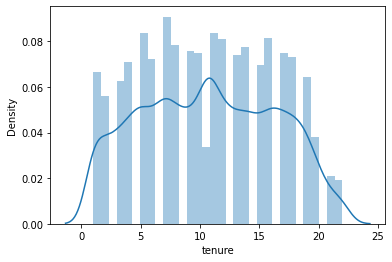

In [32]:
sns.distplot(data_cls.tenure)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


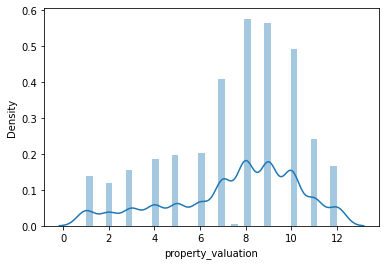

In [33]:
sns.distplot(data_cls.property_valuation)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


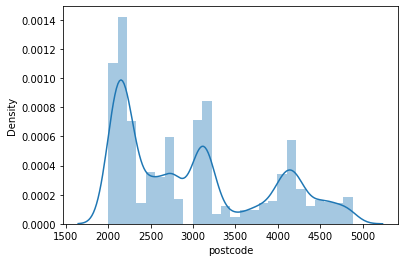

In [29]:
sns.distplot(data_cls.postcode)

Use mean imputation to impute tenure and property_valuation vars


In [30]:
data_cls['tenure'].fillna(value=data_cls['tenure'].mean(), axis=0, inplace=True)
data_cls['property_valuation'].fillna(value=data_cls['property_valuation'].mean(), axis=0, inplace=True)

It's better to say postcode is a categorical var instead of numerical var 

### Preprocess the data for Regression

In [15]:
# Select the columns used for droping
col_drop_reg = fulldata_col_notin_ncl.copy()
col_drop_reg.remove('list_price')

['customer_id', 'default', 'transaction_id', 'product_id', 'transaction_date', 'online_order', 'order_status', 'brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost', 'product_first_sold_date']


In [17]:
data_reg = full_data.drop(labels=col_drop_reg, axis=1)

In [19]:
print(data_reg.shape)
test_col = [col for col in data_reg.columns if col not in new_customer_list.columns]
print(test_col)

(20504, 17)
['list_price']


In [18]:
data_reg.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,list_price
0,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,235.63
0,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,1577.53
0,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,1720.70
0,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,360.40
0,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0,71.49


Column No Need For Training

first_name, last_name, default

In [ ]:
full_data.info()

In [ ]:
# col_in_fulldata is col should be used to train model
col_in_fulldata = [col for col in full_data.columns if col in new_customer_list.columns]
print(col_in_fulldata, len(col_in_fulldata))
print(new_customer_list.shape)

In [ ]:
col_drop = [col for col in full_data.columns if col not in col_in_fulldata]
print(col_drop, len(col_drop))

In this project, I'm going to use classification machine learning algorithm to output the proper customer segmentation

First step is to seek what features the "NewCustomerList" dataset has

In [ ]:
col_new_cus_list = new_customer_list.columns
col_new_cus_list

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [ ]:
# wanted_new_cus_list = new_customer_list.drop(labels=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
#        'Unnamed: 19', 'Unnamed: 20'], axis=1)
# wanted_new_cus_list.head()

In [ ]:
# print(wanted_new_cus_list.columns, len(wanted_new_cus_list.columns))

The customer name should help nothing with our modeling, so it should be droped

But as for gender, we should find out is there any correlation between it and target value in trainning dataset

In [ ]:
# wanted_new_cus_list = wanted_new_cus_list.drop(labels=['first_name', 'last_name'], axis=1)
# wanted_new_cus_list.columns

We should join other 3 datasets together to find same features which could be used in the trainning

we can find:

* CustomerDemographic: ['customer_id', 'gender', 'past_3_years_bike_related_purchases', 'DOB', 'job_title', 'job_industry_category', 'wealth_segment', 'deceased_indicator', 'owns_car', 'tenure'] -> 10

* 

In [ ]:
# new_cus_list_col = wanted_new_cus_list.columns.to_list()

# trans_col = transactions.columns.to_list()
# cus_demo_col = customer_demographic.columns.to_list()
# cus_add_col = customer_address.columns.to_list()

# print(trans_col)
# print(cus_demo_col)
# print(cus_add_col)

In [ ]:
# trans_col_in_nclc = [col for col in trans_col if col in new_cus_list_col]
# cus_demo_col_in_nclc = [col for col in cus_demo_col if col in new_cus_list_col]
# cus_add_col_in_nclc = [col for col in cus_add_col if col in new_cus_list_col]

# print(trans_col_in_nclc, len(trans_col_in_nclc))
# print(cus_demo_col_in_nclc, len(cus_demo_col_in_nclc))
# print(cus_add_col_in_nclc, len(cus_add_col_in_nclc))